# What we get from OSA

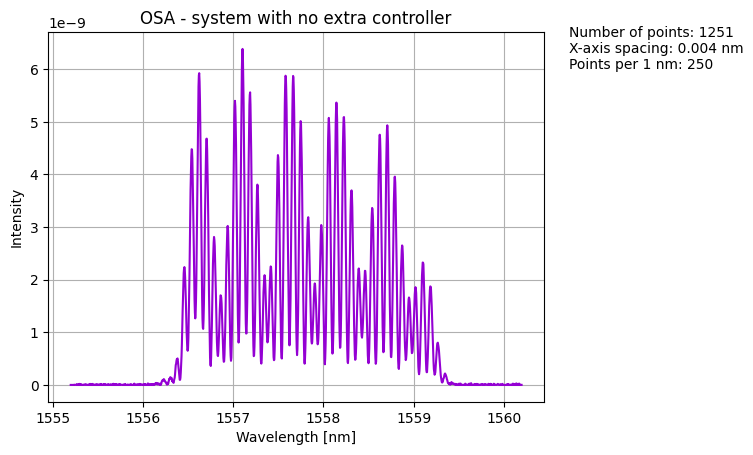

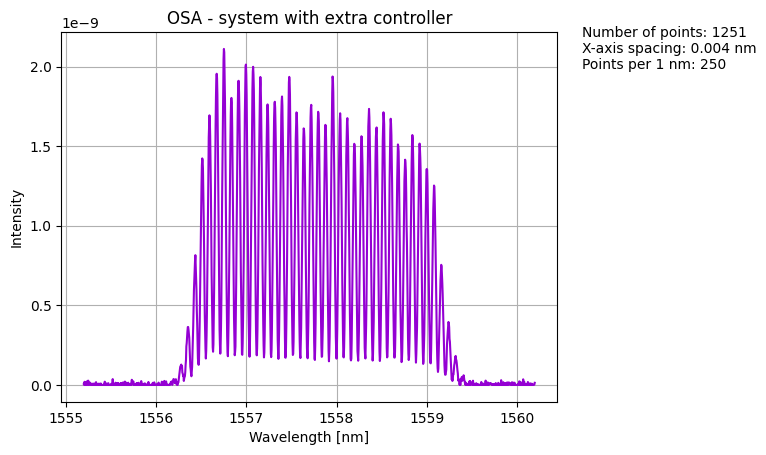

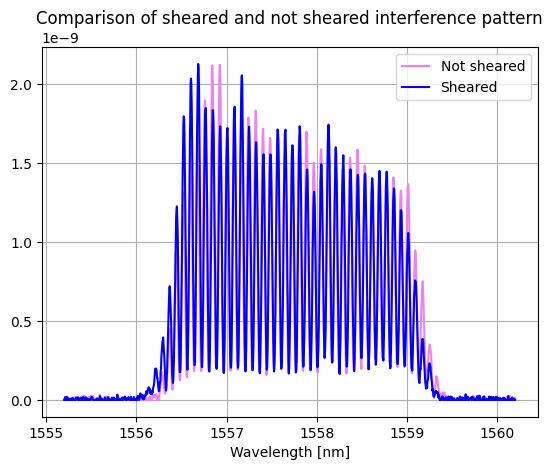

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spectral_analysis as sa
from math import floor
import importlib
import sys
module = sys.modules["spectral_analysis"]
importlib.reload(module)

no_controller = pd.read_csv("data/no_controller.csv", skiprows = 2)
controller = pd.read_csv("data/controller.csv", skiprows = 2)
sheared = pd.read_csv("data/sheared.csv", skiprows = 2)
not_sheared = pd.read_csv("data/notsheared.csv", skiprows = 2)

def to_spectrum(df):
    X = df.values[:, 0]
    Y = df.values[:, 1]
    return sa.spectrum(X, Y, "wl", "intensity")

no_controller = to_spectrum(no_controller)
controller = to_spectrum(controller)
sheared = to_spectrum(sheared)
not_sheared = to_spectrum(not_sheared)


sa.plot(no_controller, title = "OSA - system with no extra controller")
sa.plot(controller, title = "OSA - system with extra controller")
#sa.plot(not_sheared, title = "OSA - spectrum for SPIDER - not sheared")
#sa.plot(sheared, title = "OSA - spectrum for SPIDER - sheared")
sa.compare_plots([not_sheared, sheared], title = "Comparison of sheared and not sheared interference pattern", legend = ["Not sheared", "Sheared"])

# Fourier transform of spectrum with no extra controller

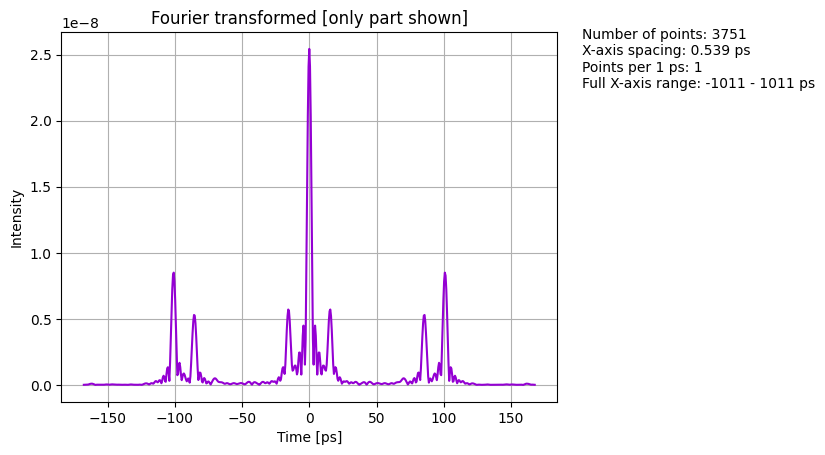

In [157]:
# zero padding

no_controller.zero_padding(1)

# transform X-axis to frequency

s_freq = no_controller.wl_to_freq(inplace = False)
s_freq.constant_spacing()
min = s_freq.quantile(0.1)
max = s_freq.quantile(0.1)
delta = (max-min)
min_freq = min-delta
max_freq = max+delta

# fourier transform

s_ft = s_freq.fourier(inplace = False)

min = s_ft.quantile(0.1)
max = s_ft.quantile(0.9)
delta = (max-min)/3
min_time = min-delta
max_time = max+delta

sa.plot(s_ft, title = "Fourier transformed", start = min_time, end = max_time) 

# Fourier transform of spectrum with extra controller

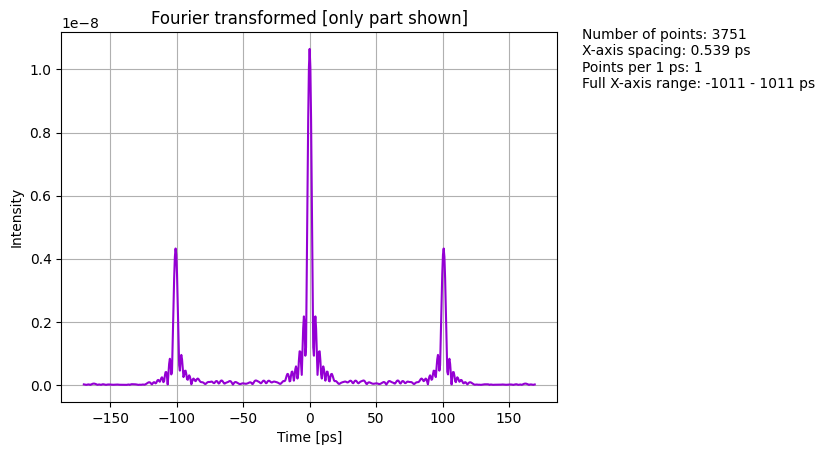

In [158]:
# zero padding

controller.zero_padding(1)

# transform X-axis to frequency

s_freq = controller.wl_to_freq(inplace = False)
s_freq.constant_spacing()
min = s_freq.quantile(0.1)
max = s_freq.quantile(0.1)
delta = (max-min)
min_freq = min-delta
max_freq = max+delta

# fourier transform

s_ft = s_freq.fourier(inplace = False)

min = s_ft.quantile(0.1)
max = s_ft.quantile(0.9)
delta = (max-min)/3
min_time = min-delta
max_time = max+delta

sa.plot(s_ft, title = "Fourier transformed", start = min_time, end = max_time) 

# Yyyyyy... okey. Didn't expect it to work. Let's do SPIDER.

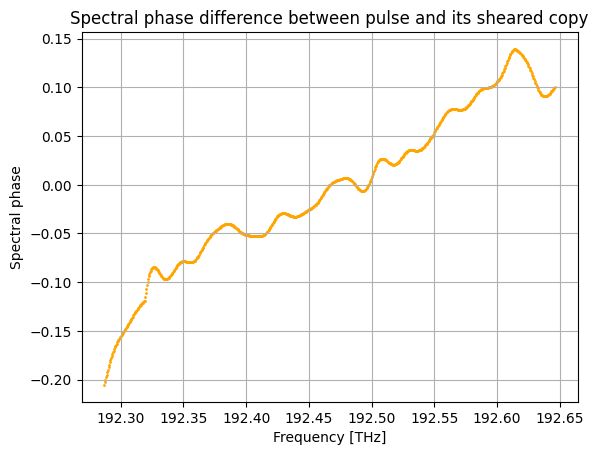

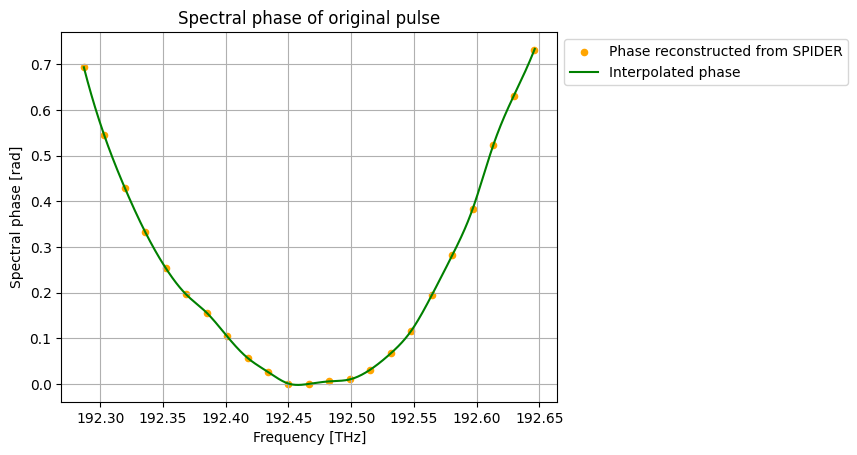

In [159]:
start = 192.27
end = 192.63

pulse = sa.spider(phase_spectrum = "data/sheared.csv",
        temporal_spectrum = "data/notsheared.csv",
        shear = None,
        intensity_spectrum = None,
        phase_borders = [start, end],
        what_to_return = "phase",
        vis_param = 0.5,
        smoothing_period = 0.065,
        plot_steps = False,
        plot_shear = False,
        plot_phase = True,
        plot_pulse = False)[1]

# and compare it with simulation

In [160]:
X = pulse.X

def phase(f, f_mean, fiber_length):
    l_0 = 1560
    c = 3*1e8
    D_l = 17
    omega = f*2*np.pi
    omega_mean = f_mean*2*np.pi
    return l_0**2*fiber_length*D_l/(4*np.pi*c)*(omega-omega_mean)**2

phase = np.vectorize(phase)

Y = phase(X, np.mean(X), 82)

sim_pulse = sa.spectrum(X, Y, "freq", "phase")
freq_spectrum = not_sheared.wl_to_freq()
sa.plot(freq_spectrum, title = "Data directly from OSA")
sa.compare_plots([pulse, sim_pulse], title = "Reconstructed vs. simulated phase", legend = ["Experiment", "Simulation"])

C:\Users\rewas\AppData\Local\Temp\ipykernel_27092\3564344547.py:9: RuntimeWarning: overflow encountered in long_scalars
  return l_0**2*fiber_length*D_l/(4*np.pi*c)*(omega-omega_mean)**2


AttributeError: 'NoneType' object has no attribute 'copy'

# let's modify spider

In [ ]:
def spider(phase_spectrum, 
           temporal_spectrum, 
           shear, 
           spectrum_in = "wl",
           intensity_spectrum = None,
           phase_borders = None,
           what_to_return = None,
           vis_param = None,
           smooth_period = None,
           plot_steps = True, 
           plot_phase = True, 
           plot_pulse = True):
    '''
    Performs SPIDER algorithm.

    ARGUMENTS:

    phase_spectrum - spectrum with interference pattern created in a SPIDER setup. I should be a pandas DataFrame with wavelength or frequency in first column and intensity in the second OR path of .csv file with that data.

    shear - spectral shear applied by EOPM given in frequency units (default THz). If \"None\", then shear is estimated using fourier filtering.

    spectrum_in - either "wl" or "freq". Specify units of the first column of loaded spectra.

    intensity_spectrum - amplitude of initial not interfered pulse. Similar as "phase_spectrum" it might be either DataFrame of string. If "None", then its approximation derived from SPIDER algorithm is used.  
    
    phase_borders - specify range of frequencies (in THz), where you want to find spectral phase. If to big, boundary effects may appear. If "None", the borders are estimated by calculating quantiles of intensity.

    what_to_return - if None, then RETURNS nothing. If "pulse", then RETURNS DataFrame with reconstructed pulse. If "phase", then RETURNS tuple with two DataFrame - phase and interpolated phase.

    plot_steps - if to plot all intermediate steps of the SPIDER algorithm.

    plot_phase - if to plot found spectral phase.

    plot_pulse - if to plot reconstructed pulse.
    '''
    import pandas as pd
    import numpy as np
    from math import floor as flr
    import spectral_analysis as sa
    import matplotlib.pyplot as plt

    # load data - spider

    if isinstance(phase_spectrum, pd.DataFrame):
        spectrum = phase_spectrum

    elif isinstance(phase_spectrum, str):    
        spectrum = pd.read_csv(phase_spectrum, skiprows = 2)

    spectrum = sa.zero_padding(spectrum, 1)

    # load data - temporal phase

    if isinstance(temporal_spectrum, pd.DataFrame):
        t_spectrum = temporal_spectrum

    elif isinstance(temporal_spectrum, str):    
        t_spectrum = pd.read_csv(temporal_spectrum, skiprows = 2)

    t_spectrum = sa.zero_padding(t_spectrum, 1)

    # plot OSA

    minimum = sa.quantile(spectrum, 0.1)
    maximum = sa.quantile(spectrum, 0.9)
    delta = (maximum-minimum)
    min_wl = minimum-delta
    max_wl = maximum+delta 

    if plot_steps and spectrum_in == "wl":
        sa.plot(spectrum, "orange", title = "Data from OSA", start = min_wl, end = max_wl, x_type = "wl")
    if plot_steps and spectrum_in == "freq":
        sa.plot(spectrum, "orange", title = "Data from OSA", start = min_wl, end = max_wl, x_type = "freq")

    # transform X-axis to frequency

    # spider

    if spectrum_in == "wl":
        s_freq = sa.wl_to_freq(spectrum)
        s_freq = sa.constant_spacing(s_freq)
        minimum = sa.quantile(s_freq, 0.1)
        maximum = sa.quantile(s_freq, 0.9) 
        delta = (maximum-minimum)
        min_freq = minimum-delta
        max_freq = maximum+delta
        if plot_steps: 
            sa.plot(s_freq,"orange", title = "Wavelength to frequency", x_type = "freq", start = min_freq, end = max_freq)

    elif spectrum_in == "freq":
        s_freq = spectrum
        minimum = sa.quantile(s_freq, 0.1)
        maximum = sa.quantile(s_freq, 0.9) 
        delta = (maximum-minimum)
        min_freq = minimum-delta
        max_freq = maximum+delta

    s_freq_for_later = s_freq.copy()

    # temporal

    if spectrum_in == "wl":
        s_freq_t = sa.wl_to_freq(t_spectrum)
        s_freq_t = sa.constant_spacing(s_freq_t)

    elif spectrum_in == "freq":
        s_freq_t = t_spectrum

    # fourier transform

    s_ft = sa.fourier(s_freq, absolute = False)         # spider
    s_ft_t = sa.fourier(s_freq_t, absolute = False)     # temporal

    s_shear = s_ft.copy()       # SPOILER: we will use it later to find the shear
    s_shear_t = s_ft_t.copy()

    minimum = sa.quantile(s_ft, 0.1)
    maximum = sa.quantile(s_ft, 0.9)
    delta = (maximum-minimum)/3
    min_time = minimum-delta
    max_time = maximum+delta
   
    if plot_steps: 
        sa.plot(s_ft, title = "Fourier transformed", x_type = "time", start = min_time, end = max_time) 

    # estimate time delay
    
    if vis_param == None:
        height = sa.find_visibility(s_freq_t)
    else:
        height = vis_param
    period = sa.find_period(s_freq_t, height)[0]
    delay = 1/period

    # find exact value of time delay

    s_ft2 = s_ft.copy()
    s_ft2 = sa.replace_with_zeros(s_ft2, start = "min", end = delay*0.5)
    s_ft2 = sa.replace_with_zeros(s_ft2, start = delay*1.5, end = "max")
    
    idx = s_ft2.values[:, 1].argmax()
    if isinstance(idx, np.ndarray): 
        idx = idx[0]
    delay2 = s_ft.values[idx, 0]
    
    # and filter the spectrum to keep only one of site peaks
    
    s_ft = sa.replace_with_zeros(s_ft, start = "min", end = delay2*0.5)         # spider
    s_ft = sa.replace_with_zeros(s_ft, start = delay2*1.5, end = "max")

    s_ft_t = sa.replace_with_zeros(s_ft_t, start = "min", end = delay2*0.5)     # temporal
    s_ft_t = sa.replace_with_zeros(s_ft_t, start = delay2*1.5, end = "max")

    if plot_steps: 
        sa.plot(s_ft, title = "Filtered", x_type = "time", start = -2*delay2, end = 2*delay2)

    # let's find the shear
    
    if shear == None:

        s_shear = sa.replace_with_zeros(s_shear, start = "min", end = -delay2*0.5)          # spider
        s_shear = sa.replace_with_zeros(s_shear, start = delay2*0.5, end = "max")

        s_shear_t = sa.replace_with_zeros(s_shear_t, start = "min", end = -delay2*0.5)      # temporal
        s_shear_t = sa.replace_with_zeros(s_shear_t, start = delay2*0.5, end = "max")
        
        s_shear = sa.inv_fourier(s_shear)
        s_shear_t = sa.inv_fourier(s_shear_t)

        X_shear = np.real(s_shear.values[:, 0])
        Y_shear = np.abs(s_shear.values[:, 1])
        Y_shear_t = np.abs(s_shear_t.values[:, 1])

        Y_shear_t /= 2
        Y_shear -= Y_shear_t

        Y_shear = pd.DataFrame(np.transpose(np.stack((X_shear, Y_shear))))
        Y_shear_t = pd.DataFrame(np.transpose(np.stack((X_shear, Y_shear_t))))

        Y_shear = sa.replace_with_zeros(Y_shear, start = "min", end = -0.5)
        Y_shear = sa.replace_with_zeros(Y_shear, start = 0.5, end = "max")

        Y_shear_t = sa.replace_with_zeros(Y_shear_t, start = "min", end = -0.5)
        Y_shear_t = sa.replace_with_zeros(Y_shear_t, start = 0.5, end = "max")
        
        shear = sa.find_shift(Y_shear, Y_shear_t, spectrum_in = "freq")
        if True:
            sa.compare_plots([Y_shear, Y_shear_t], 
                             start = -0.6, 
                             end = 0.6, 
                             abs = True, 
                             title = "Shear of {} THz".format(round(shear,5)),
                             legend = ["Sheared", "Not sheared"])

    integrate_interval = flr(shear/(np.mean(np.diff(s_freq_for_later.values[:, 0]))))
    mean = np.mean(s_freq_for_later.values[:, 0])
        
    # inverse fourier

    s_ift = sa.inv_fourier(s_ft)        # spider
    s_ift_t = sa.inv_fourier(s_ft_t)    # temporal
    if plot_steps:
        s_ift2 = s_ift.copy()
        s_ift2.values[:, 0] += mean 
        sa.plot(s_ift2, title = "Inverse Fourier transformed", x_type = "freq", start = min_freq, end = max_freq, what_to_plot = "abs")

    # cut spectrum to area of significant phase

    if phase_borders == None:
        min_phase = sa.quantile(s_ift, 0.05)
        max_phase = sa.quantile(s_ift, 0.95)

    else:
        min_phase = phase_borders[0] - mean
        max_phase = phase_borders[1] - mean

    s_cut = sa.cut(s_ift, start = min_phase, end = max_phase)
    s_cut_t = sa.cut(s_ift_t, start = min_phase, end = max_phase)

    # extract phase differences

    phase_values = s_cut.values[:, 1].copy()
    temporal_phase = s_cut_t.values[:, 1].copy()
    X = s_cut.values[:, 0].copy()

    phase_values = np.angle(phase_values)
    temporal_phase = np.angle(temporal_phase)

    # extract phase

    values = phase_values - temporal_phase
    values -= values[0]                     # deletes linear aberration in phase

    def kill_oscillations(period, values):
        spacing = np.mean(np.diff(X))
        idx_period = flr(period/spacing)

        new_values = []
        for i in range(len(values)):
            left = np.max([i-flr(idx_period/2), 0])
            right = np.min([i+flr(idx_period/2), len(values) - 1])
            new_values.append(np.mean(values[left:right]))
        
        return new_values
    
    values = np.unwrap(values)
    values = kill_oscillations(smooth_period, values)
    values -= values[flr(len(values)/2)]    # without that line, spectral phase will later always start at zero and grow

    # prepare data to plot
    
    X = X + mean + shear
    X2 = X.copy()

    # plot phase difference

    if plot_phase:

        plt.scatter(X, np.real(values), color = "orange", s = 1)
        plt.title("Spectral phase difference between pulse and its sheared copy")
        plt.xlabel("Frequency [THz]")
        plt.ylabel("Spectral phase")
        plt.grid()
        plt.show()

    # and plot phase

    X = X[::integrate_interval]
    values = values[::integrate_interval]

    Y = np.cumsum(values)

    phase_frame_old = pd.DataFrame(np.transpose(np.stack((X, Y))))
    interpolated_phase_old = sa.interpolate(phase_frame_old, X2)

    Y2 = interpolated_phase_old.values[:, 1]
    Y -= Y2[flr(len(Y2)/2)]

    phase_frame = pd.DataFrame(np.transpose(np.stack((X, Y))))
    interpolated_phase = sa.interpolate(phase_frame, X2)

    if plot_phase:

        plt.scatter(X, Y, color = "orange", s = 20)
        plt.plot(interpolated_phase.values[:,0], interpolated_phase.values[:,1], color = "green")
        plt.title("Spectral phase of original pulse")
        plt.legend(["Phase reconstructed from SPIDER", "Interpolated phase"], bbox_to_anchor = [1, 1])
        plt.xlabel("Frequency [THz]")
        plt.ylabel("Spectral phase [rad]")
        plt.grid()
        plt.show()

    # recover intensity spectrum

    if intensity_spectrum == None:
        intensity = s_cut.copy()
        s_cut.values[:,:] = np.abs(s_cut.values[:,:])
    
    else:
        if isinstance(intensity_spectrum, pd.DataFrame):
            intensity = intensity_spectrum
        elif isinstance(intensity_spectrum, str):
            intensity = pd.read_csv(intensity_spectrum, skiprows = 2)
        if spectrum_in == "wl":
            intensity = sa.wl_to_freq(intensity)
            intensity = sa.constant_spacing(intensity)
        start = np.searchsorted(intensity.values[:, 0], interpolated_phase.values[0, 0])
        num = len(interpolated_phase.values[:, 0])
        end = start + num
        intensity = sa.cut(intensity, start = start, end = end, how = "index")

    # extract the pulse

    interpolated_phase2 = sa.zero_padding(interpolated_phase, 2)  
    intensity = sa.zero_padding(intensity, 2) 

    pulse = sa.recover_pulse(interpolated_phase2, intensity)

    if plot_pulse:
        min_pulse = sa.quantile(pulse, 0.25)
        max_pulse = sa.quantile(pulse, 0.75)
        delta = (max_pulse-min_pulse)*3
        sa.plot(pulse, color = "red", title = "Recovered pulse", x_type = "time", start = min_pulse-delta, end = max_pulse+delta, what_to_plot = "abs")

    # return what's needed

    if what_to_return == "pulse":
        return pulse
    elif what_to_return == "phase":
        return phase_frame, interpolated_phase

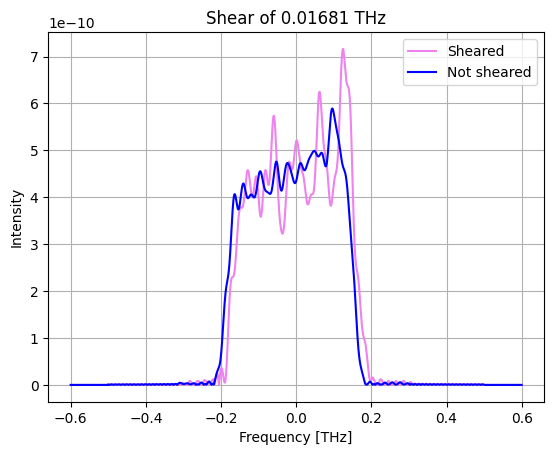

C:\Users\rewas\AppData\Local\Temp\ipykernel_27092\270742840.py:236: ComplexWarning: Casting complex values to real discards the imaginary part
  idx_period = flr(period/spacing)
d:\Users\rewas\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


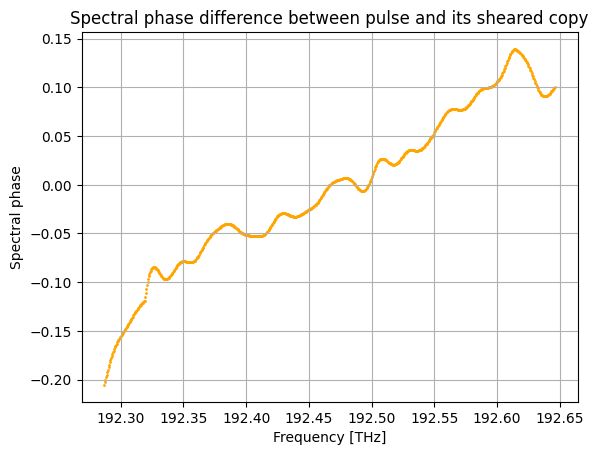

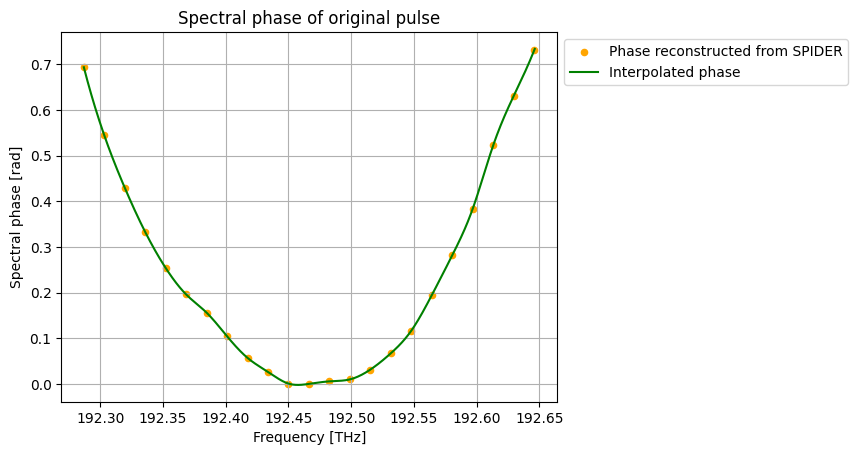

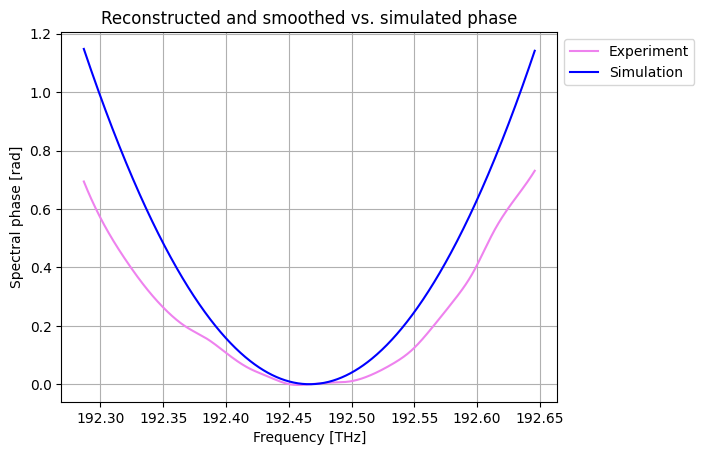

In [ ]:
start = 192.27
end = 192.63

pulse = spider(phase_spectrum = "data/sheared.csv",
        temporal_spectrum = "data/notsheared.csv",
        shear = None,
        intensity_spectrum = None,
        phase_borders = [start, end],
        spectrum_in = "wl",
        what_to_return = "phase",
        smooth_period = 0.065,
        vis_param = 0.5,
        plot_steps = False,
        plot_phase = True,
        plot_pulse = False)[1]

sa.compare_plots([pulse, sim_pulse], title = "Reconstructed and smoothed vs. simulated phase", legend = ["Experiment", "Simulation"], y_type = "phase")